# Soft Actor-Critic for Model-free Learning-based Control
## Solving the Regulation Problem of an Inverted Pendulum on a Cart
> Intelligent Control and Fault Diagnosis course - Spring 2025 - Amirkabir University of Technology (Tehran Polytechnic)<br>
> Author: Mahdi Shahrajabian  <br>
> Ref:
>> [1] Haarnoja, Tuomas, Aurick Zhou, Pieter Abbeel, and Sergey Levine. "Soft actor-critic: Off-policy maximum entropy deep reinforcement learning with a stochastic actor." In International conference on machine learning, pp. 1861-1870. Pmlr, 2018. <br>
>> [2] Haarnoja, Tuomas, Aurick Zhou, Kristian Hartikainen, George Tucker, Sehoon Ha, Jie Tan, Vikash Kumar et al. "Soft actor-critic algorithms and applications." arXiv preprint arXiv:1812.05905 (2018). <br>
>> [3] https://spinningup.openai.com/en/latest/algorithms/sac.html#references

In [ ]:
!pip install control

In [1]:
import numpy as np
import gymnasium as gym
import control as ct
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings 
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
warnings.filterwarnings("ignore")  
import tensorflow.keras as keras
import tensorflow_probability as tfp 
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.patches as patches
import matplotlib.animation as animation
from IPython.display import Video, display
import cv2
from IP_Env import InvertedPendulumCart

In [2]:
print("TensorFlow %s" % tf.__version__)
print("tfp %s" % tfp.__version__)
print("Keras %s" % keras.__version__)
print("gym %s" % gym.__version__)
print("numpy %s" % np.__version__)

TensorFlow 2.18.0
tfp 0.25.0
Keras 3.6.0
gym 1.0.0
numpy 1.26.4


In [2]:
class ReplayBuffer:
    def __init__(self, max_size, input_shape, n_actions):
        self.m_size = max_size
        self.m_cntr = 0
        self.state_m = np.zeros((self.m_size, *input_shape))
        self.new_state_m = np.zeros((self.m_size, *input_shape))
        self.action_m = np.zeros((self.m_size, n_actions))
        self.reward_m = np.zeros(self.m_size)
        self.terminal_m = np.zeros(self.m_size)

    def store(self, state, action, reward, state_, done):
        id = self.m_cntr % self.m_size

        self.state_m[id] = state
        self.new_state_m[id] = state_
        self.action_m[id] = action
        self.reward_m[id] = reward
        self.terminal_m[id] = done

        self.m_cntr += 1

    def sample(self, batch_size):
        max_m = min(self.m_cntr, self.m_size)

        batch = np.random.choice(max_m, batch_size)

        states = self.state_m[batch]
        states_ = self.new_state_m[batch]
        actions = self.action_m[batch]
        rewards = self.reward_m[batch]
        dones = self.terminal_m[batch]

        return states, actions, rewards, states_, dones

In [3]:
class CriticNetwork(keras.Model):
    def __init__(self, n_actions, fc1_dims=256, fc2_dims=256, name='critic'):
        super(CriticNetwork, self).__init__()
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.model_name = name

        self.fc1 = Dense(self.fc1_dims, activation='relu')
        self.fc2 = Dense(self.fc2_dims, activation='relu')
        self.q = Dense(1, activation=None)

    def call(self, state, action):
        action_value = self.fc1(tf.concat([state, action], axis=1))
        action_value = self.fc2(action_value)

        q = self.q(action_value)

        return q

In [4]:
class ValueNetwork(keras.Model):
    def __init__(self, fc1_dims=256, fc2_dims=256, name='value'):
        super(ValueNetwork, self).__init__()
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.model_name = name

        self.fc1 = Dense(self.fc1_dims, activation='relu')
        self.fc2 = Dense(fc2_dims, activation='relu')
        self.v = Dense(1, activation=None)

    def call(self, state):
        state_value = self.fc1(state)
        state_value = self.fc2(state_value)

        v = self.v(state_value)

        return v

In [5]:
class ActorNetwork(keras.Model):
    def __init__(self, max_action, fc1_dims=256,
            fc2_dims=256, n_actions=1, name='actor'):
        super(ActorNetwork, self).__init__()
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.model_name = name
        self.max_action = max_action
        self.noise = 1e-6

        self.fc1 = Dense(self.fc1_dims, activation='relu')
        self.fc2 = Dense(self.fc2_dims, activation='relu')
        self.mu = Dense(self.n_actions, activation=None)
        self.sigma = Dense(self.n_actions, activation=None)

    def call(self, state):
        prob = self.fc1(state)
        prob = self.fc2(prob)

        mu = self.mu(prob)
        sigma = self.sigma(prob)
        sigma = tf.clip_by_value(sigma, self.noise, 0.2)  # Reduce upper bound to make the policy smoother but may result in less exploration

        return mu, sigma

    def sample_normal(self, state, reparameterize=True):
        mu, sigma = self.call(state)

        if reparameterize:
            # During training: Reparameterization trick
            # sample epsilon from standard normal, and then transform it using mu and sigma
            epsilon = tf.random.normal(shape=mu.shape)
            actions = mu + epsilon * sigma
        else:
            # During action selection, directly sample from the normal distribution
            probabilities = tfp.distributions.Normal(mu, sigma)
            actions = probabilities.sample()

        # Apply tanh squashing
        action = tf.math.tanh(actions)

        # Calculate log probabilities (using the original normal distribution)
        probabilities = tfp.distributions.Normal(mu, sigma)
        log_probs = probabilities.log_prob(actions)

        # Apply the squashing correction
        log_probs -= tf.math.log(1 - tf.math.pow(action, 2) + self.noise)
        log_probs = tf.math.reduce_sum(log_probs, axis=1, keepdims=True)

        return action, log_probs

In [6]:
class Agent:
    def __init__(self, alpha=0.0003, beta=0.0003, input_dims=[4],
            env=None, gamma=0.99, n_actions=1, max_size=1000000, tau=0.005,
            layer1_size=256, layer2_size=256, batch_size=256, reward_scale=2):
        self.gamma = gamma
        self.tau = tau
        self.memory = ReplayBuffer(max_size, input_dims, n_actions)
        self.batch_size = batch_size
        self.n_actions = n_actions

        # Initialize temperature parameter (alpha) and its optimizer
        # Reduced initial entropy to make the agent prioritize stability over exploration
        self.log_alpha = tf.Variable(tf.math.log(0.1), dtype=tf.float32)  
        self.alpha_T = tf.exp(self.log_alpha)
        self.alpha_optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)

        # Optional: Set target entropy (can also be set in learn method)
        ##self.target_entropy = -np.prod(env.action_space.shape)
        # Lower the target entropy gain to encourage the policy to select more deterministic actions
        self.target_entropy = -tf.cast(self.n_actions, dtype=tf.float32)

        self.actor = ActorNetwork(n_actions=n_actions, name='actor',
                                    max_action=env.action_space.high)
        self.critic_1 = CriticNetwork(n_actions=n_actions, name='critic_1')
        self.critic_2 = CriticNetwork(n_actions=n_actions, name='critic_2')
        self.value = ValueNetwork(name='value')
        self.target_value = ValueNetwork(name='target_value')

        self.actor.compile(optimizer=Adam(learning_rate=alpha))
        self.critic_1.compile(optimizer=Adam(learning_rate=beta))
        self.critic_2.compile(optimizer=Adam(learning_rate=beta))
        self.value.compile(optimizer=Adam(learning_rate=beta))
        self.target_value.compile(optimizer=Adam(learning_rate=beta))

        self.scale = reward_scale
        self.update_network_parameters(tau=1)

    def choose_action(self, observation, deterministic=False):
        state = tf.convert_to_tensor([observation])
        
        if deterministic:
            mu, _ = self.actor.call(state)
            action = tf.math.tanh(mu)  # Deterministic action
        else:
            action, _ = self.actor.sample_normal(state, reparameterize=False)
        
        return action[0]

    def remember(self, state, action, reward, new_state, done):
        self.memory.store(state, action, reward, new_state, done)

    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        weights = []
        targets = self.target_value.weights
        for i, weight in enumerate(self.value.weights):
            weights.append(weight * tau + targets[i]*(1-tau))

        self.target_value.set_weights(weights)

    def learn(self):
        if self.memory.m_cntr < self.batch_size:
            return 0, 0, 0, 0

        state, action, reward, new_state, done = \
                self.memory.sample(self.batch_size)

        states = tf.convert_to_tensor(state, dtype=tf.float32)
        states_ = tf.convert_to_tensor(new_state, dtype=tf.float32)
        rewards = tf.convert_to_tensor(reward, dtype=tf.float32)
        actions = tf.convert_to_tensor(action, dtype=tf.float32)

        # Update temperature parameter

        # target_entropy = -tf.cast(tf.shape(action)[-1], dtype=tf.float32)
        # with tf.GradientTape() as tape:
        #     _, log_probs = self.actor.sample_normal(states, reparameterize=True)
        #     log_probs = tf.squeeze(log_probs, 1)
        #     alpha_loss = -tf.reduce_mean(
        #         self.log_alpha * tf.stop_gradient(log_probs + target_entropy))

        # alpha_gradient = tape.gradient(alpha_loss, [self.log_alpha])
        # self.alpha_optimizer.apply_gradients(zip(alpha_gradient, [self.log_alpha]))
        # self.alpha_T = tf.exp(self.log_alpha)

        with tf.GradientTape() as tape:
            value = tf.squeeze(self.value(states), 1)
            value_ = tf.squeeze(self.target_value(states_), 1)

            current_policy_actions, log_probs = self.actor.sample_normal(states,
                                                        reparameterize=False)
            log_probs = tf.squeeze(log_probs,1)
            q1_new_policy = self.critic_1(states, current_policy_actions)
            q2_new_policy = self.critic_2(states, current_policy_actions)
            critic_value = tf.squeeze(
                                tf.math.minimum(q1_new_policy, q2_new_policy), 1)

            value_target = critic_value - self.alpha_T * log_probs
            value_loss = 0.5 * keras.losses.MSE(value, value_target)

        value_network_gradient = tape.gradient(value_loss,
                                                self.value.trainable_variables)
        self.value.optimizer.apply_gradients(zip(
                       value_network_gradient, self.value.trainable_variables))

        with tf.GradientTape() as tape:
            new_policy_actions, log_probs = self.actor.sample_normal(states,
                                                reparameterize=True)
            log_probs = tf.squeeze(log_probs, 1)
            q1_new_policy = self.critic_1(states, new_policy_actions)
            q2_new_policy = self.critic_2(states, new_policy_actions)
            critic_value = tf.squeeze(tf.math.minimum(
                                        q1_new_policy, q2_new_policy), 1)

            actor_loss = self.alpha_T * log_probs - critic_value
            actor_loss = tf.math.reduce_mean(actor_loss)
            log_probs_2 = log_probs

        actor_network_gradient = tape.gradient(actor_loss,
                                            self.actor.trainable_variables)
        self.actor.optimizer.apply_gradients(zip(
                        actor_network_gradient, self.actor.trainable_variables))

        with tf.GradientTape(persistent=True) as tape:
            q_hat = self.scale * reward + self.gamma * value_ * (1 - tf.cast(done, tf.float32))
            #q_hat = self.scale*reward + self.gamma*value_*(1-done)
            q1_old_policy = tf.squeeze(self.critic_1(state, action), 1)
            q2_old_policy = tf.squeeze(self.critic_2(state, action), 1)
            critic_1_loss = 0.5 * keras.losses.MSE(q1_old_policy, q_hat)
            critic_2_loss = 0.5 * keras.losses.MSE(q2_old_policy, q_hat)

        critic_1_network_gradient = tape.gradient(critic_1_loss,
                                        self.critic_1.trainable_variables)
        critic_2_network_gradient = tape.gradient(critic_2_loss,
            self.critic_2.trainable_variables)

        self.critic_1.optimizer.apply_gradients(zip(
            critic_1_network_gradient, self.critic_1.trainable_variables))
        self.critic_2.optimizer.apply_gradients(zip(
            critic_2_network_gradient, self.critic_2.trainable_variables))

        self.update_network_parameters()

        return value_loss, actor_loss, critic_1_loss, critic_2_loss


## System Description
<center>
<img src="IP.png" alt="pendulum" width=250/>
</center>
The state-space representation of the inverted pendulum on a cart system is as follows:
$$\begin{align}
& (M+m)\ddot{x}+m\ell\ddot{\theta} \cos(\theta) - m \ell \dot{\theta}^2 \sin(\theta) = F \\
& m\ell \ddot{x}\cos(\theta) + m \ell^2\ddot{\theta}-mg\ell\sin(\theta) = 0
\end{align}
$$

$$\mathbf{x} = \begin{bmatrix} x & \dot{x} & \theta & \dot{\theta} \end{bmatrix}, \quad u = F $$
$$ \begin{align*}
\dot{\mathbf{x}} = 
\begin{bmatrix}
\dot{x}\\ \ddot{x} \\ \dot{\theta} \\ \ddot{\theta}
\end{bmatrix} &=
\begin{bmatrix}
\dot{x} \\
\dfrac{F+m\ell\dot{\theta}\sin(\theta)-mg\cos(\theta)\sin(\theta)}{M+m(1-\cos^2(\theta))} \\
\dot{\theta} \\
\dfrac{(M+m)g\sin(\theta)-u\cos(\theta)-m\ell\dot{\theta}^2\sin(\theta)\cos(\theta)}{\ell (M+m(1-\cos^2(\theta))}
\end{bmatrix} \\
&= \begin{bmatrix}
x_2 \\
\dfrac{u+m\ell x_4\sin(x_3)-mg\cos(x_3)\sin(x_3)}{M+m(1-\cos^2(x_3))} \\
x_4 \\
\dfrac{(M+m)g\sin(x_3)-u\cos(x_3)-m\ell x_4^2\sin(x_3)\cos(x_3)}{\ell (M+m(1-\cos^2(x_3))}
\end{bmatrix}\\
y &= x_3
\end{align*}
$$
$m$ is the pendulum's mass, $M$ is the cart's mass, $\ell$ is the pendulum's length and $g$ is the gravitational acceleration. Moreover, $u$ indicates the system control For input.

The linearized model of the system around $(0,0)$ is 
$$
A = \begin{bmatrix}
0 & 1 & 0 & 0\\
0 & 0 & -\frac{m g}{M} & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & \frac{g(M+m)}{LM} & 0
\end{bmatrix}, \quad 
B = \begin{bmatrix}
0 \\ \frac{1}{M} \\ 0 \\ -\frac{1}{LM}
\end{bmatrix}
$$

## LQR 
$$
J = \int_{0}^{\infty} (x^TQx + u^TRu)dt
$$

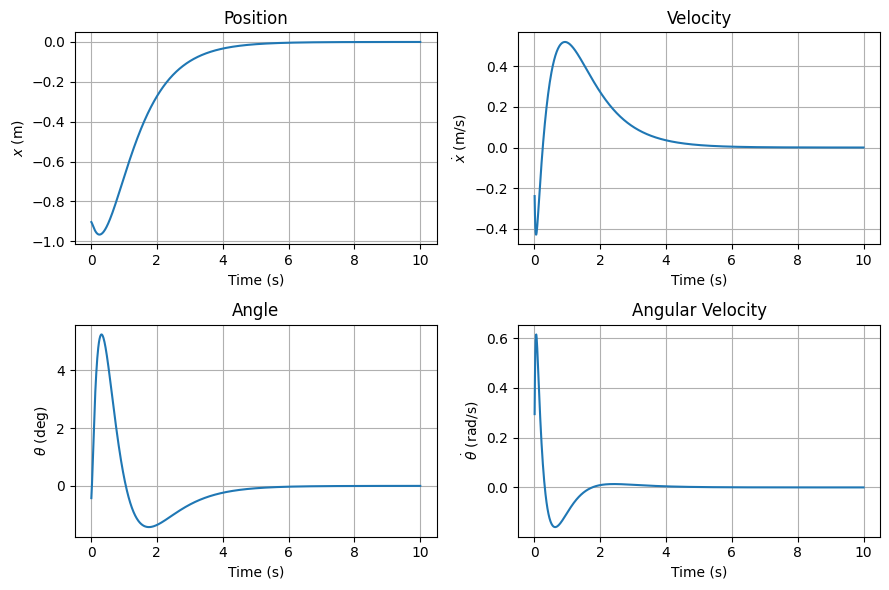

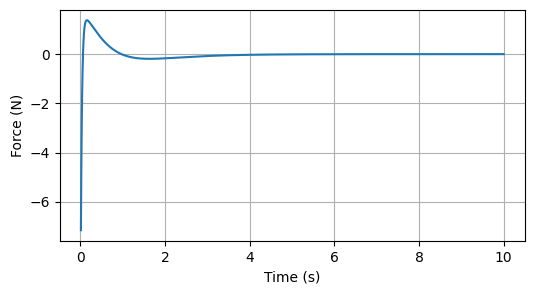

In [7]:
def LinDyn(x, u, A, B):
    x_dot = A@x+B@u
    return x_dot.reshape(-1,1)
    
def LinSim(A, B, x0, x_d, K, T_f=10, dt=0.01):
    time_history, state_history, control_history = [], [], []
    t_vec = np.linspace(0, T_f, int(T_f/dt))  
    t = 0
    x = x0
    for i in range(len(t_vec)):
        u = -K@x
        k1 = LinDyn(x, u, A=A, B=B)
        k2 = LinDyn(x + 0.5*dt*k1, u, A=A, B=B)
        k3 = LinDyn(x + 0.5*dt*k2, u, A=A, B=B)
        k4 = LinDyn(x + dt*k3, u, A=A, B=B)

        x = (x + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)).reshape(-1,1)
        t += dt
        control_history.append(u.flatten())
        state_history.append(x.flatten()) 
        time_history.append(t)
        
    results = {
        "time_hist": np.array(time_history),
        "state_hist": np.array(state_history),
        "control_hist": np.array(control_history)}
    return results

def plot_states(time, state,name):
    state = np.array(state, dtype=np.float64)
    state[:,2] = np.degrees(state[:,2])  
    posvel_vec = state[:,0:2]
    ang_vec = state[:,2:4]
    fig, axes = plt.subplots(2, 2, figsize=(9, 6))
    titles = [['Position', 'Velocity'],
              ['Angle', 'Angular Velocity']]
    y_labels = [[r'$x$ (m)', r'$\dot{x}$ (m/s)'], 
                [r'$\theta$ (deg)', r'$\dot{\theta}$ (rad/s)']]
    
    for i in range(2):  
        for j in range(2):
            axes[i, j].set_title(titles[i][j])
            axes[i, j].set_xlabel('Time (s)')
            axes[i, j].set_ylabel(y_labels[i][j])
            axes[i, j].grid()
            if i==0:
                axes[i, j].plot(time, posvel_vec[:,j]) 
            else:
                axes[i, j].plot(time, ang_vec[:,j]) 

    plt.tight_layout()
    plt.savefig(name, bbox_inches='tight')
    plt.show()
    
m = 0.2 # Mass of the pendulum (kg)
M = 0.5 # mass of the cart (kg)
L = 0.6 # Length of the pendulum (m)
g = 9.81 # Gravitational acceleration (m/s^2)
A=np.array([[0, 1, 0, 0],
              [0 ,  0 , -m*g/M , 0],
              [0 , 0 ,  0 , 1], 
              [0,  0, g*(m+M)/(M*L), 0]])
B=np.array([[0],[1/M],[0],[-1/(M*L)]])

# States: [x x_dot theta theta_dot]
Q = np.diag([0.1, 0.1, 1, 0.1]) # state weighting matrix
R = np.array([[0.002]]) # input weighting matrix

# K - gain matrix 
# S - solution of the Riccati equation 
# E - closed-loop eigenvalues 
K, S, E = ct.lqr(A, B, Q, R)

initial_min_vals = np.array([-1, -0.5, -0.1, -0.1], dtype=np.float32)
initial_max_vals = np.array([1, 0.5, 0.1, 0.1], dtype=np.float32)
        
x0 = np.random.uniform(low=initial_min_vals, high=initial_max_vals).reshape(-1,1)
x_d = np.array([0,0,0,0]).reshape(-1,1)
results = LinSim(A, B, x0, x_d, K, T_f=10, dt=0.01)
plot_states(results["time_hist"], results["state_hist"], "IP_LQR_states.pdf")

plt.figure(figsize=(6, 3))
plt.plot(results["time_hist"], results["control_hist"])
plt.grid()
plt.xlabel('Time (s)')
plt.ylabel('Force (N)')
plt.savefig("IP_LQR_control.pdf", bbox_inches='tight')
plt.show()

## Main

In [8]:
%%time
env = InvertedPendulumCart(m=m, M=M, L=L, u_min=-10, u_max=10, Q=Q, R=R, r_T=-30, dt=0.05)
agent = Agent(input_dims=env.observation_space.shape, env=env,
              n_actions=env.action_space.shape[0])
n_episodes = 150
n_steps = 200  # 10 seconds

score_history = []
value_losses = []
actor_losses = []
critic_1_losses = []
critic_2_losses = []
episode_length = []

x_d = np.array([0,0,0,0]).reshape(-1,1)
for i in range(n_episodes):
    state = env.reset()
    done = False
    score = 0
    steps = 0
    for t in range(n_steps):
        steps += 1
        action = agent.choose_action(state)

        state_, reward, done = env.step(action.numpy(),x_d)  
        score += reward

        agent.remember(state, action, reward, state_, done)
        value_loss, actor_loss, critic_1_loss, critic_2_loss = agent.learn()
        state = state_
        if done:
            break
    score_history.append(score)
    episode_length.append(steps)
    value_losses.append(value_loss)
    actor_losses.append(actor_loss)
    critic_1_losses.append(critic_1_loss)
    critic_2_losses.append(critic_2_loss)

    avg_score = np.mean(score_history[-100:])
    if (i+1) % 5 == 0:
        print(f"Episode: {i+1:4d} | "
              f"Ep Length: {int(steps):4d} | "
              f"Score: {int(score):4d} | "
              f"Avg Score: {int(avg_score):4d} | "
              f"Actor Loss: {actor_loss:.2f} | "
              f"Critic 1 Loss: {critic_1_loss:.2f} | "
              f"Critic 2 Loss: {critic_2_loss:.2f} | "
              f"Value Loss: {value_loss:.2f}")


Episode:    5 | Ep Length:   43 | Score: -160 | Avg Score:  -98 | Actor Loss: 0.00 | Critic 1 Loss: 0.00 | Critic 2 Loss: 0.00 | Value Loss: 0.00
Episode:   10 | Ep Length:   46 | Score: -167 | Avg Score:  -91 | Actor Loss: 1.29 | Critic 1 Loss: 162.40 | Critic 2 Loss: 163.27 | Value Loss: 0.16
Episode:   15 | Ep Length:   46 | Score: -433 | Avg Score: -136 | Actor Loss: 14.03 | Critic 1 Loss: 33.25 | Critic 2 Loss: 33.16 | Value Loss: 0.16
Episode:   20 | Ep Length:  166 | Score: -349 | Avg Score: -176 | Actor Loss: 20.92 | Critic 1 Loss: 10.81 | Critic 2 Loss: 10.84 | Value Loss: 0.10
Episode:   25 | Ep Length:   99 | Score: -411 | Avg Score: -197 | Actor Loss: 29.02 | Critic 1 Loss: 39.27 | Critic 2 Loss: 39.30 | Value Loss: 0.89
Episode:   30 | Ep Length:  114 | Score: -293 | Avg Score: -218 | Actor Loss: 44.08 | Critic 1 Loss: 191.60 | Critic 2 Loss: 190.30 | Value Loss: 0.71
Episode:   35 | Ep Length:  166 | Score: -379 | Avg Score: -238 | Actor Loss: 62.64 | Critic 1 Loss: 201.4

# Results

In [9]:
# Save the model weights 
agent.actor.save_weights("sac_actor.weights.h5")
agent.critic_1.save_weights("sac_critic1.weights.h5")
agent.critic_2.save_weights("sac_critic2.weights.h5")
agent.value.save_weights("sac_value.weights.h5")
agent.target_value.save_weights("sac_target_value.weights.h5")
np.save("log_alpha.npy", agent.log_alpha.numpy())

# Load
# agent.actor.load_weights("sac_actor.weights.h5")
# agent.critic_1.load_weights("sac_critic1.weights.h5")
# agent.critic_2.load_weights("sac_critic2.weights.h5")
# agent.value.load_weights("sac_value.weights.h5")
# agent.target_value.load_weights("sac_target_value.weights.h5")
# agent.log_alpha.assign(np.load("log_alpha.npy"))
# agent.alpha_T = tf.exp(agent.log_alpha)

## Learning curves

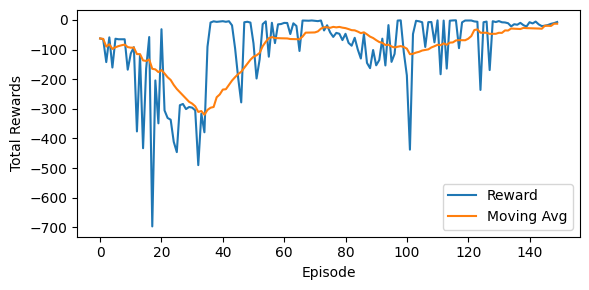

In [13]:
def running_avg(totalrewards):
    N = len(totalrewards)
    totalrewards = np.array(totalrewards)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = totalrewards[max(0, t-20):(t+1)].mean()
    return running_avg
plt.figure(figsize=(6, 3))
plt.plot(score_history,label='Reward')
plt.plot(running_avg(score_history), label='Moving Avg')
plt.xlabel('Episode')
plt.ylabel('Total Rewards')
plt.legend()
plt.tight_layout()
plt.savefig("IP_SAC_r.pdf", bbox_inches='tight')
plt.show()

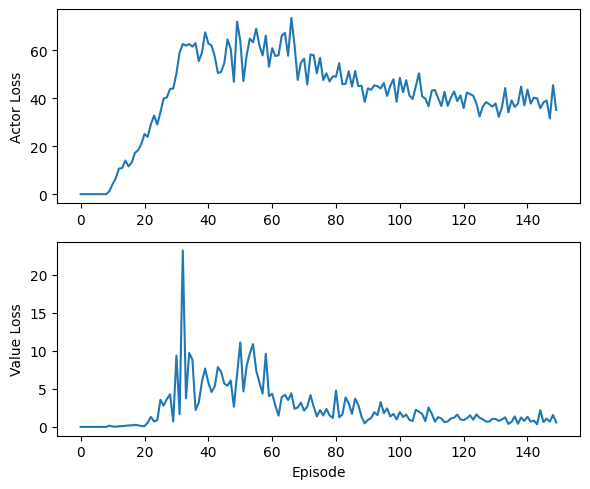

In [14]:
plt.figure(figsize=(6, 5))
plt.subplot(2, 1, 1)
plt.plot(actor_losses)
# plt.xlabel('Episode')
plt.ylabel('Actor Loss')
plt.subplot(2, 1, 2)
plt.plot(value_losses)
plt.xlabel('Episode')
plt.ylabel('Value Loss')
plt.tight_layout()
plt.savefig("IP_SAC_AVloss.pdf", bbox_inches='tight')
plt.show()

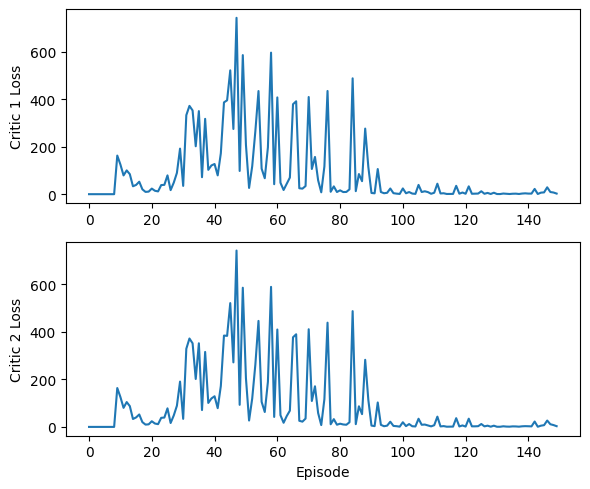

In [15]:
plt.figure(figsize=(6, 5))
plt.subplot(2, 1, 1)
plt.plot(critic_1_losses)
# plt.xlabel('Episode')
plt.ylabel('Critic 1 Loss')
plt.subplot(2, 1, 2)
plt.plot(critic_2_losses)
plt.xlabel('Episode')
plt.ylabel('Critic 2 Loss')
plt.tight_layout()
plt.savefig("IP_SAC_Closs.pdf", bbox_inches='tight')
plt.show()

In [21]:
def simulation(agent, x_d, num_experiences, num_timesteps = 200):
    state_history = []
    time_history = []
    action_history = []

    env = InvertedPendulumCart(m=m, M=M, L=L, u_min=-10, u_max=10, Q=Q, R=R, r_T=-5, dt=0.05)
    for i in range(num_experiences):
        state = env.reset()
        for _ in range(num_timesteps):
            action = agent.choose_action(state,deterministic=True)
            state, reward, done= env.step(action,x_d)
            state_history.append(state)
            time_history.append(env.t)
            action = env.denormalize_action(action)
            action_history.append(action)
            if done:
                break
    return time_history, state_history, action_history
    
x_d = np.array([0,0,0,0]).reshape(-1,1)
time_history, state_history, action_history = simulation(agent,x_d,10)
t_episode = time_history[0:200]
x_episode = state_history[0:200]
u_episode = action_history[0:200]

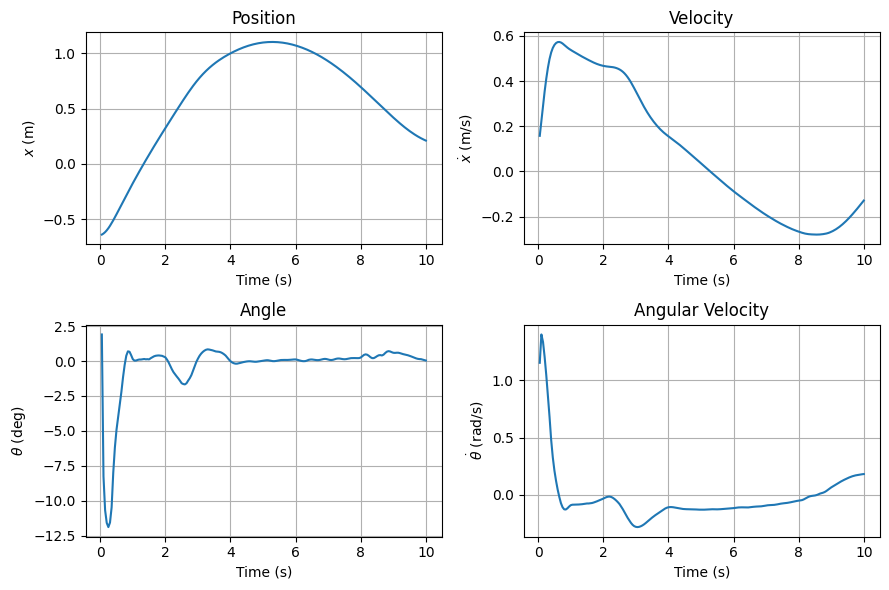

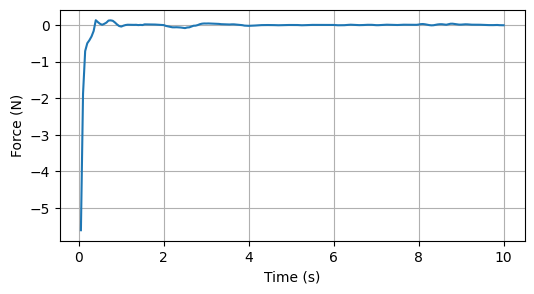

In [22]:
plot_states(t_episode, x_episode, "IP_SAC_state.pdf")

plt.figure(figsize=(6, 3))
plt.plot(t_episode, u_episode)
plt.grid()
plt.xlabel('Time (s)')
plt.ylabel('Force (N)')
plt.savefig("IP_SAC_control.pdf", bbox_inches='tight')
plt.show()

## Render the learned policy

In [23]:
def render(t, state):
    cart_width = 0.5  
    cart_height = 0.3  
    wheel_radius = 0.05  
    pendulum_length = 0.8 
    pendulum_mass_radius = 0.07  
    video_path = "inverted_pendulum_render.mp4"
    fps = 20 # 1/dt
    
    state = np.array(state)
    x = state[:, 0] 
    theta = state[:, 2]  
    
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.set_xlim(-2, 2)
    ax.set_ylim(-0.7, 1.2)
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Z-axis")
    ax.set_title("Inverted Pendulum on a Cart")
    ax.set_aspect('equal', 'box')
    
    frame_width, frame_height = 600, 400  
    fourcc = cv2.VideoWriter_fourcc(*'avc1')
    out = cv2.VideoWriter(video_path, fourcc, fps, (frame_width, frame_height))
    
    for i in range(len(x)):
        ax.clear()
        ax.set_xlim(-2, 2)
        ax.set_ylim(-0.7, 1.2)
        
        cart = patches.Rectangle((x[i] - cart_width / 2, -cart_height ),
                                 cart_width, cart_height, color='blue')
        ax.add_patch(cart)
        
        wheel_left = patches.Circle((x[i] - cart_width / 3, -cart_height - wheel_radius),
                                    wheel_radius, color='black')
        wheel_right = patches.Circle((x[i] + cart_width / 3, -cart_height - wheel_radius),
                                     wheel_radius, color='black')
        ax.add_patch(wheel_left)
        ax.add_patch(wheel_right)
        
        pendulum_x = x[i] + pendulum_length * np.sin(theta[i])
        pendulum_y = pendulum_length * np.cos(theta[i])
        
        ax.plot([x[i], pendulum_x], [0, pendulum_y], color='red', linewidth=2)
        
        pendulum_mass = patches.Circle((pendulum_x, pendulum_y), pendulum_mass_radius, color='red')
        ax.add_patch(pendulum_mass)

        ax.plot([-2, 2], [-cart_height- 2.2*wheel_radius, -cart_height- 2.2*wheel_radius], 'k-', linewidth=3)  # Ground line

        ax.set_title(f"Inverted Pendulum on a Cart\nTime: {t[i]:.2f} sec")

        fig.canvas.draw()
        img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        img_resized = cv2.resize(img, (frame_width, frame_height))
        out.write(cv2.cvtColor(img_resized, cv2.COLOR_RGB2BGR))
    
    out.release()
    plt.close(fig)
    display(Video(video_path))
    
render(t_episode,x_episode)

## State histogram

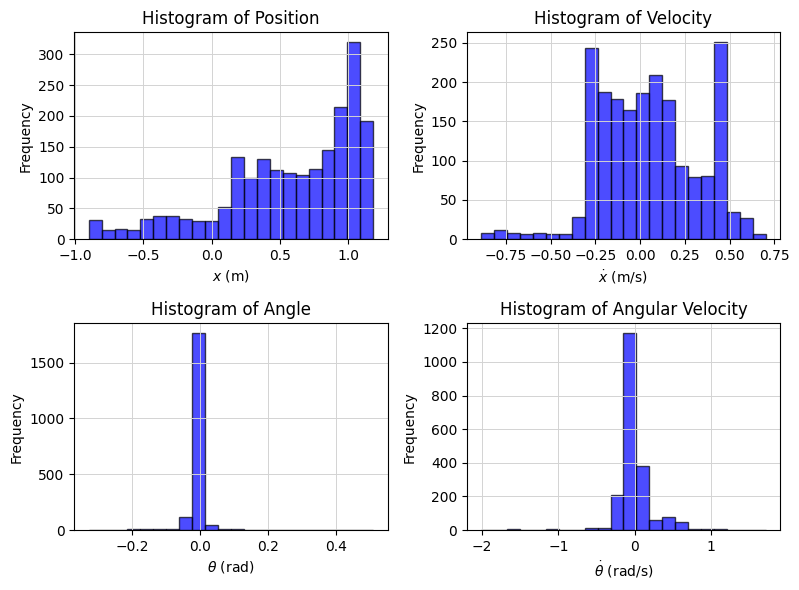

In [24]:

titles = ['Position', 'Velocity', 'Angle', 'Angular Velocity']
y_labels = [r'$x$ (m)', r'$\dot{x}$ (m/s)', r'$\theta$ (rad)', r'$\dot{\theta}$ (rad/s)']

all_states = np.vstack(state_history) 
plt.figure(figsize=(8, 6))
for i in range(4):
    plt.subplot(2, 2, i + 1) 
    plt.hist(all_states[:,i],bins=22,  alpha=0.7,color='blue',edgecolor='black')
    plt.title(f'Histogram of {titles[i]}')
    plt.xlabel(y_labels[i])
    plt.ylabel('Frequency')
    plt.gca().set_facecolor('white')
    plt.grid(color='lightgray', linestyle='-', linewidth=0.7)

plt.tight_layout()  
plt.savefig("IP_SAC_histogram.pdf", bbox_inches='tight') 
plt.show()